In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class StripesData(Dataset):
    def __init__(self, n_stripes, res, num_examples):
        self.n_stripes = n_stripes
        self.res = res
        self.num_examples = num_examples
    
    def __len__(self):
        return self.num_examples
    
    def __getitem__(self, idx):
        # Generate a random image
        pix = np.linspace(0, 1, self.res)
        J, I = np.meshgrid(pix, pix)
        p = np.random.rand()
        x = np.cos(2*np.pi*(self.n_stripes*I + p))
        y = 0
        if np.random.rand() > 0.5:
            y = 1
            x = np.sign(x)
        x = torch.from_numpy(np.array(x.flatten(), dtype=np.float32))
        y = torch.from_numpy(np.array(y, dtype=np.float32))
        return x, y, p

res = 50
stripes = StripesData(4, res, 5000)

In [3]:
perceptron = nn.Linear(50*50, 1)
optimizer = torch.optim.Adam(perceptron.parameters(), lr=1e-6)
loss_fn = nn.BCEWithLogitsLoss()
n_epochs = 50
losses = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)
for epoch in range(n_epochs):
    loader = DataLoader(stripes, batch_size=50, shuffle=True)
    total_loss = 0
    total_correct = 0
    for X, Y, P in loader:
        optimizer.zero_grad()
        Y_est = perceptron(X).flatten()
        loss = loss_fn(Y_est, Y)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        total_loss += loss
        Y_est = torch.round(torch.sigmoid(Y_est))
        total_correct += torch.sum(Y_est == Y)
    
    a = total_correct.cpu().detach()/len(stripes)
    losses[epoch] = loss
    accuracy[epoch] = a
    print(loss, a)


0.6719913482666016 tensor(0.4898)
0.715514600276947 tensor(0.4880)
0.6899784207344055 tensor(0.4954)
0.6896713972091675 tensor(0.4828)
0.7054449319839478 tensor(0.4876)
0.7041143774986267 tensor(0.4700)
0.6897883415222168 tensor(0.4780)
0.685016930103302 tensor(0.4600)
0.7011821866035461 tensor(0.4672)
0.6941847205162048 tensor(0.4234)
0.6821058392524719 tensor(0.3432)
0.7011334896087646 tensor(0.3710)
0.6882756948471069 tensor(0.2698)
0.6864593625068665 tensor(0.2824)
0.6908087134361267 tensor(0.2598)
0.6898201704025269 tensor(0.3722)
0.6984124183654785 tensor(0.3366)
0.6872714161872864 tensor(0.3154)
0.6911876201629639 tensor(0.2742)
0.7040415406227112 tensor(0.2924)
0.6898849606513977 tensor(0.3662)
0.7073145508766174 tensor(0.3402)
0.7062370777130127 tensor(0.3682)
0.6891181468963623 tensor(0.3710)
0.6962727904319763 tensor(0.3358)
0.7032231092453003 tensor(0.2638)
0.6932541131973267 tensor(0.2602)
0.7022073268890381 tensor(0.2776)
0.7034410238265991 tensor(0.4198)
0.69690096378326

Examining the weights, I seem to have learned nothing

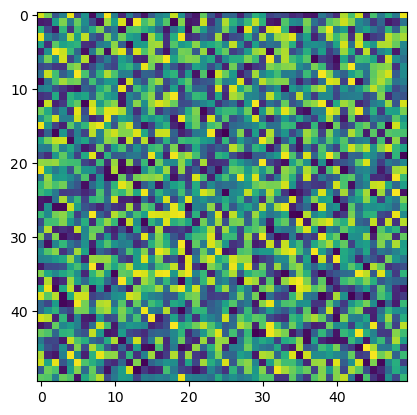

In [4]:
W = next(iter(perceptron.parameters()))
plt.imshow(W.detach().view(res, res))

Let's do principal component analysis to project the data to lower dimensions and see if that helps us see why it's not linearly separable.  I'll be sure to draw the smooth stripes a different color from the harsh stripes so we can see

In [5]:
loader = DataLoader(stripes, batch_size=len(stripes))
X, Y, P = next(iter(loader))
X = X.numpy()
Y = Y.numpy()
P = P.numpy()

from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Directions in my 2500 dimensional
# data space of highest variance
XDR = pca.fit_transform(X) # Project data onto two dimensions of
# highest variance

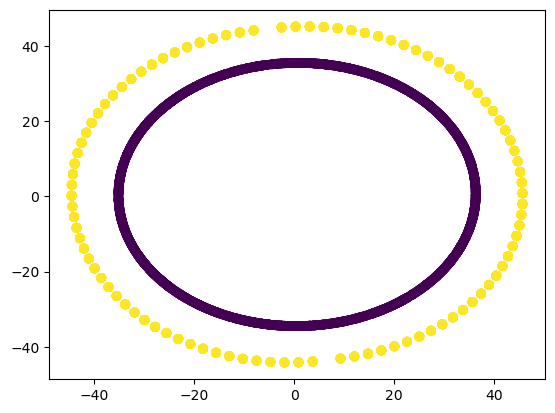

In [6]:
plt.scatter(XDR[:, 0], XDR[:, 1], c=Y)

In [ ]:
idx = np.argsort(P)
plt.figure(figsize=(12, 6))
frame = 0
for i in idx:
    if Y[i] == 1:
        Xi = np.reshape(X[i, :], (res, res))
        plt.clf()
        plt.subplot(121)
        plt.scatter(XDR[:, 0], XDR[:, 1], c=Y)
        plt.scatter(XDR[i, 0], XDR[i, 1], s=200)
        plt.legend(["_", "Data Point"])
        plt.title("PCA")
        plt.xlabel("First principal component")
        plt.ylabel("Second principal component")
        plt.subplot(122)
        plt.imshow(Xi, cmap='gray')
        plt.title("Data point")
        plt.savefig("Frame{}.png".format(frame))
        frame += 1

The animations below go through the points sorted by phase, which gives an idea of how the data is organized in the space

<img src = "Cosine.gif">

<img src = "Square.gif">

We can understand mathematically that the smooth stripes actually just live on a 2 dimensional plane in 2500 dimensional space

np.cos(2*np.pi*(self.n_stripes*I + p))

$ \cos(2 \pi n y + \phi)$, where $\phi$ varies, but $n$ is fixed

$\cos(2\pi n y)\cos(\phi) + \sin(2\pi n y) \sin(phi)$

So I can get to any shifted smooth stripe by doing a linear combination of the two images $\cos(2\pi n y)$ and $\sin(2\pi n y)$


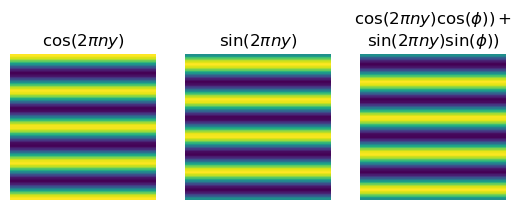

In [10]:
phi = np.pi*1.5
pix = np.linspace(0, 1, 50)
J, I = np.meshgrid(pix, pix)
plt.subplot(131)
C = np.cos(2*np.pi*4*I)
plt.imshow(C)
plt.axis("off")
plt.title("$\\cos(2 \pi n y)$")
plt.subplot(132)
plt.axis("off")
S = np.sin(2*np.pi*4*I)
plt.imshow(S)
plt.title("$\\sin(2 \pi n y)$")
plt.subplot(133)
plt.imshow(np.cos(phi)*C + np.sin(phi)*S)
plt.axis("off")
plt.title("$\\cos(2 \pi n y) \\cos(\\phi)) +$\n$\\sin(2 \pi n y) \\sin(\\phi))$");

On the other hand, to represent the "harsh" square stripes, I need to use the <a href = "https://en.wikipedia.org/wiki/Square_wave">fourier series for a square wave</a>:

## $ f(y) = \frac{4}{\pi} \left( \sin(2\pi n y) + \frac{1}{3} \sin(6 \pi n y) + \frac{1}{5} \sin( 10 \pi n y \right) + \frac{1}{7} \sin(14 \pi n y) + .. $

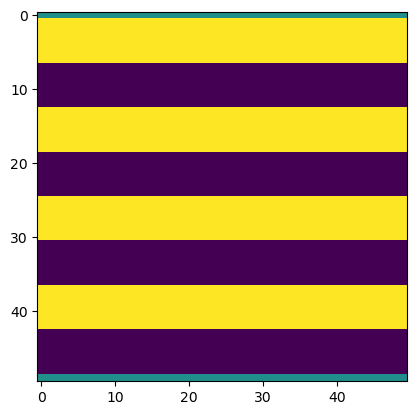

In [11]:
img = np.zeros((res, res))
for i in range(2500//2):
    k = 2*i+1
    img += (4/np.pi)*np.sin(2*np.pi*4*k*I)/k
plt.imshow(img)

## $ f(y + \phi) = \frac{4}{\pi} \left( \sin(2\pi n (y + \phi)) + \frac{1}{3} \sin(6 \pi n (y + \phi)) + \frac{1}{5} \sin( 10 \pi n (y + \phi) \right) + \frac{1}{7} \sin(14 \pi n (y + \phi)) + .. $

With a phase shift, the first two dimensions will be shared with the smooth stripe, but we need a new pair of dimensions for every higher harmonic